In [1]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from refiners.fluxion.utils import manual_seed, no_grad
from anydoor_refiners.preprocessing import preprocess_images
from anydoor_refiners.model import AnyDoor, AnydoorAutoencoder
from anydoor_refiners.dinov2 import DINOv2Encoder
from anydoor_refiners.unet import UNet
from anydoor_refiners.controlnet import ControlNet

torch.set_num_threads(2)

In [2]:
# device1 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device2 = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device3 = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
# device4 = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
dtype = torch.float16

In [3]:
lda = AnydoorAutoencoder(device=device, dtype=dtype)
encoder = DINOv2Encoder(device=device,dtype=dtype)
unet = UNet(4,device=device,dtype=dtype)
controlnet = ControlNet(4,device=device,dtype=dtype)
anydoor = AnyDoor(
    unet=unet,
    lda=lda,
    control_model=controlnet,
    object_encoder=encoder,
    device=device, # Only for solver
    dtype=dtype,
)

In [4]:
anydoor.unet.load_from_safetensors("ckpt/unet.safetensors")
anydoor.control_model.load_from_safetensors("ckpt/controlnet.safetensors")
anydoor.object_encoder.load_from_safetensors("ckpt/dinov2_encoder.safetensors")
anydoor.lda.load_from_safetensors("ckpt/lda.safetensors")
True # to avoid printing the model summary

True

In [5]:
# hyperparameters
seed = 42
uncod_scale = 5.0
num_inference_steps = 50
anydoor.set_inference_steps(num_inference_steps, first_step=0)

In [6]:
background_image_path = 'examples/background.png'
background_mask_path = 'examples/background_mask.png'
object_image_path = 'examples/object.png'

object_image = cv2.imread(object_image_path, cv2.IMREAD_UNCHANGED)
object_mask = (object_image[:,:,-1] > 128).astype(np.uint8)
object_image = object_image[:,:,:-1]
object_image = cv2.cvtColor(object_image.copy(), cv2.COLOR_BGR2RGB)
ref_image = object_image 
ref_mask = object_mask

# background image
back_image = cv2.imread(background_image_path).astype(np.uint8)
back_image = cv2.cvtColor(back_image, cv2.COLOR_BGR2RGB)

# background mask 
tar_mask = cv2.imread(background_mask_path)[:,:,0] > 128
tar_mask = tar_mask.astype(np.uint8)

preprocessed_images = preprocess_images(ref_image, ref_mask, back_image.copy(), tar_mask)

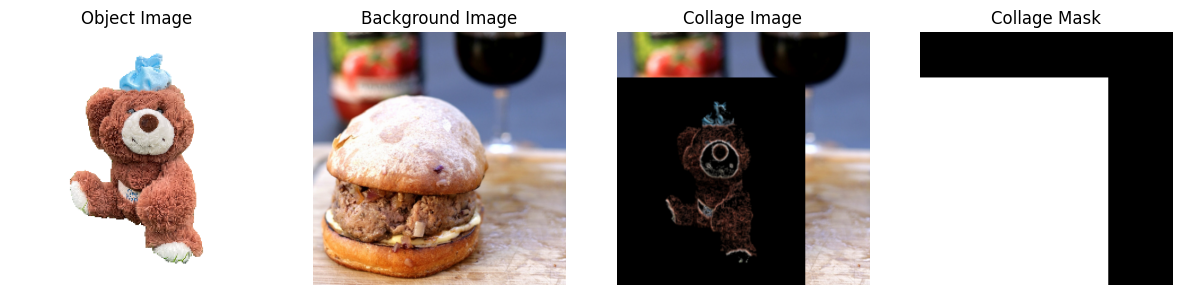

In [7]:
def display_images(images):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    for i, (title, img) in enumerate(images.items()):
        # Rescale image if it's in the range [-1, 1] to [0, 1]
        if np.min(img) < 0 or np.max(img) > 1:
            img = (img + 1) / 2  # Rescale from [-1, 1] to [0, 1]
        axs[i].imshow(img)
        axs[i].axis("off")
        axs[i].set_title(title)
    plt.show()

display_images({
    "Object Image": preprocessed_images["object"] ,
    "Background Image": preprocessed_images["background"] ,
    "Collage Image": preprocessed_images["collage"][:,:,:-1] ,
    "Collage Mask": np.stack([preprocessed_images["collage"][:,:,-1]] * 3, axis=-1) ,
})

In [8]:
control_tensor = torch.from_numpy(preprocessed_images['collage'] .copy()).to( device=device,dtype = dtype).unsqueeze(0).permute(0,3,1,2)
object_tensor = torch.from_numpy(preprocessed_images['object'].copy()).to(device=device ,dtype = dtype).unsqueeze(0).permute(0,3,1,2)

In [9]:
object_tensor.shape, control_tensor.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1, 4, 512, 512]))

In [10]:
with no_grad():  
    manual_seed(seed)
    anydoor.object_encoder.to(device="cuda:0")
    object_embedding = anydoor.object_encoder(object_tensor.to(device="cuda:0"))
    negative_object_embedding = anydoor.object_encoder(torch.zeros((object_image.shape[0], 3, 224, 224),device="cuda:0",dtype=dtype))
    # Change device object_encoder to device2
    anydoor.object_encoder.to(device=device)
    x = anydoor.init_latents((512, 512))

    # diffusion denoising process
    for step in tqdm(anydoor.steps):
        x = anydoor.forward(
            x,
            step=step,
            control_background_image= control_tensor,
            object_embedding= object_embedding,
            negative_object_embedding= negative_object_embedding,
            condition_scale= 5.0
        )
    

    # predicted_image = anydoor.lda.latents_to_image(x)




  0%|          | 0/50 [00:05<?, ?it/s]


ChainError: 

OutOfMemoryError:
   File "/home/daniel/code/anydoor-refiners/.venv/lib/python3.11/site-packages/refiners/fluxion/layers/attentions.py", line 29, in scaled_dot_product_attention
    return _scaled_dot_product_attention(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
CUDA out of memory. Tried to allocate 21.90 GiB. GPU 0 has a total capacity of 23.64 GiB of which 9.81 GiB is free. Including non-PyTorch memory, this process has 13.81 GiB memory in use. Of the allocated memory 9.39 GiB is allocated by PyTorch, and 4.23 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
---------------
(CHAIN) Attention(embedding_dim=320, num_heads=5, key_embedding_dim=1024, value_embedding_dim=1024, inner_dim=320, use_bias=False)
    ├── (DISTR)
    │   ├── Linear(in_features=320, out_features=320, device=cuda:0, dtype=float16) #1
    │   └── Linear(in_features=1024, out_features=320, device=cuda:0, dtype=float16) (x2) #2
    ├── >>> ScaledDotProductAttention(num_heads=5) | DownBlocks.Chain_2.DinoV2CrossAttention.Chain_2.CrossAttentionBlock.Residual_2.Attention.ScaledDotProductAttention
    └── Linear(in_features=320, out_features=320, device=cuda:0, dtype=float16)
0: Tensor(shape=(1, 4096, 320), dtype=float16, device=cuda:0, min=-1.70, max=1.64, mean=0.03, std=0.37, norm=427.33, grad=False)
1: Tensor(shape=(1117, 257, 320), dtype=float16, device=cuda:0, min=-6.83, max=6.39, mean=0.04, std=1.48, norm=14167.73, grad=False)
2: Tensor(shape=(1117, 257, 320), dtype=float16, device=cuda:0, min=-2.16, max=1.83, mean=-0.03, std=0.42, norm=4007.68, grad=False)
---------------
(RES) Residual()
    ├── LayerNorm(normalized_shape=(320,), device=cuda:0, dtype=float16)
    ├── (PAR)
    │   ├── Identity()
    │   └── UseContext(context=cross_attention_block, key=dinov2_object_embedding) (x2)
    └── >>> (CHAIN) Attention(embedding_dim=320, num_heads=5, key_embedding_dim=1024, value_embedding_dim=1024, inner_dim=320, use_bias=False) | DownBlocks.Chain_2.DinoV2CrossAttention.Chain_2.CrossAttentionBlock.Residual_2.Attention
        ├── (DISTR)
        │   ├── Linear(in_features=320, out_features=320, device=cuda:0, dtype=float16) #1
        │   └── Linear(in_features=1024, out_features=320, device=cuda:0, dtype=float16) (x2) #2
        ├── ScaledDotProductAttention(num_heads=5)
        └── Linear(in_features=320, out_features=320, device=cuda:0, dtype=float16)
0: Tensor(shape=(1, 4096, 320), dtype=float16, device=cuda:0, min=-1.56, max=1.38, mean=-0.01, std=0.24, norm=273.45, grad=False)
1: Tensor(shape=(1117, 257, 1024), dtype=float16, device=cuda:0, min=-3.16, max=3.82, mean=-0.02, std=0.77, norm=13285.28, grad=False)
2: Tensor(shape=(1117, 257, 1024), dtype=float16, device=cuda:0, min=-3.16, max=3.82, mean=-0.02, std=0.77, norm=13285.28, grad=False)
---------------
(CHAIN) CrossAttentionBlock(embedding_dim=320, context_embedding_dim=1024, context_key=dinov2_object_embedding, num_heads=5, use_bias=False)
    ├── (RES) Residual() #1
    │   ├── LayerNorm(normalized_shape=(320,), device=cuda:0, dtype=float16)
    │   └── (CHAIN) SelfAttention(embedding_dim=320, num_heads=5, inner_dim=320, use_bias=False)
    │       ├── (PAR) ...
    │       ├── (DISTR) ...
    │       ├── ScaledDotProductAttention(num_heads=5)
    │       └── Linear(in_features=320, out_features=320, device=cuda:0, dtype=float16)
    ├── >>> (RES) Residual() | DownBlocks.Chain_2.DinoV2CrossAttention.Chain_2.CrossAttentionBlock.Residual_2 #2
    │   ├── LayerNorm(normalized_shape=(320,), device=cuda:0, dtype=float16)
    │   ├── (PAR)
0: Tensor(shape=(1, 4096, 320), dtype=float16, device=cuda:0, min=-2.00, max=1.86, mean=0.01, std=0.21, norm=243.11, grad=False)
---------------
(CHAIN)
    └── >>> (CHAIN) CrossAttentionBlock(embedding_dim=320, context_embedding_dim=1024, context_key=dinov2_object_embedding, num_heads=5, use_bias=False) | DownBlocks.Chain_2.DinoV2CrossAttention.Chain_2.CrossAttentionBlock
        ├── (RES) Residual() #1
        │   ├── LayerNorm(normalized_shape=(320,), device=cuda:0, dtype=float16)
        │   └── (CHAIN) SelfAttention(embedding_dim=320, num_heads=5, inner_dim=320, use_bias=False) ...
        ├── (RES) Residual() #2
        │   ├── LayerNorm(normalized_shape=(320,), device=cuda:0, dtype=float16)
        │   ├── (PAR) ...
        │   └── (CHAIN) Attention(embedding_dim=320, num_heads=5, key_embedding_dim=1024, value_embedding_dim=1024, inner_dim=320, use_bias=False) ...
        └── (RES) Residual() #3
            ├── LayerNorm(normalized_shape=(320,), device=cuda:0, dtype=float16)
0: Tensor(shape=(1, 4096, 320), dtype=float16, device=cuda:0, min=-2.02, max=1.25, mean=-0.00, std=0.19, norm=218.13, grad=False)
---------------
(RES) DinoV2CrossAttention(channels=320)
    ├── (CHAIN) #1
    │   ├── GroupNorm(num_groups=32, eps=1e-06, channels=320, device=cuda:0, dtype=float16)
    │   ├── (CHAIN) StatefulFlatten(start_dim=2)
    │   │   ├── SetContext(context=flatten, key=sizes)
    │   │   └── Flatten(start_dim=2)
    │   ├── Transpose(dim0=1, dim1=2)
    │   ├── Lambda(<lambda>(x))
    │   └── Linear(in_features=320, out_features=320, device=cuda:0, dtype=float16)
    ├── >>> (CHAIN) | DownBlocks.Chain_2.DinoV2CrossAttention.Chain_2 #2
    │   └── (CHAIN) CrossAttentionBlock(embedding_dim=320, context_embedding_dim=1024, context_key=dinov2_object_embedding, num_heads=5, use_bias=False)
0: Tensor(shape=(1, 4096, 320), dtype=float16, device=cuda:0, min=-2.02, max=1.25, mean=-0.00, std=0.19, norm=218.13, grad=False)
---------------
(CHAIN)
    ├── (SUM) ResidualBlock(in_channels=320, out_channels=320)
    │   ├── (CHAIN)
    │   │   ├── GroupNorm(num_groups=32, channels=320, device=cuda:0, dtype=float16) #1
    │   │   ├── SiLU() #1
    │   │   ├── (SUM) RangeAdapter2d(channels=320, embedding_dim=1280) ...
    │   │   ├── GroupNorm(num_groups=32, channels=320, device=cuda:0, dtype=float16) #2
    │   │   ├── SiLU() #2
    │   │   └── Conv2d(in_channels=320, out_channels=320, kernel_size=(3, 3), padding=(1, 1), device=cuda:0, dtype=float16)
    │   └── Identity()
    ├── >>> (RES) DinoV2CrossAttention(channels=320) | DownBlocks.Chain_2.DinoV2CrossAttention
0: Tensor(shape=(1, 320, 64, 64), dtype=float16, device=cuda:0, min=-8.04, max=5.35, mean=-0.12, std=0.66, norm=769.64, grad=False)
---------------
(CHAIN) DownBlocks(in_channels=4)
    ├── (CHAIN) #1
    │   ├── Conv2d(in_channels=4, out_channels=320, kernel_size=(3, 3), padding=(1, 1), device=cuda:0, dtype=float16)
    │   └── (PASS) ResidualAccumulator(n=0)
    │       ├── (RES) Residual() ...
    │       └── SetContext(context=unet, key=residuals)
    ├── >>> (CHAIN) | DownBlocks.Chain_2 #2
    │   ├── (SUM) ResidualBlock(in_channels=320, out_channels=320)
    │   │   ├── (CHAIN) ...
    │   │   └── Identity()
    │   ├── (RES) DinoV2CrossAttention(channels=320)
0: Tensor(shape=(1, 320, 64, 64), dtype=float16, device=cuda:0, min=-3.09, max=3.21, mean=0.00, std=0.36, norm=409.19, grad=False)
---------------
(CHAIN) UNet(in_channels=4)
    ├── (PASS) TimestepEncoder()
    │   ├── UseContext(context=diffusion, key=timestep)
    │   ├── (CHAIN) RangeEncoder(sinusoidal_embedding_dim=320, embedding_dim=1280)
    │   │   ├── Lambda(compute_sinusoidal_embedding(x: jaxtyping.Int[Tensor, '*batch 1']) -> jaxtyping.Float[Tensor, '*batch 1 embedding_dim'])
    │   │   ├── Converter(set_device=False)
    │   │   ├── Linear(in_features=320, out_features=1280, device=cuda:0, dtype=float16) #1
    │   │   ├── SiLU()
    │   │   └── Linear(in_features=1280, out_features=1280, device=cuda:0, dtype=float16) #2
    │   └── SetContext(context=range_adapter, key=timestep_embedding)
    ├── >>> (CHAIN) DownBlocks(in_channels=4) | .DownBlocks
0: Tensor(shape=(1, 4, 64, 64), dtype=float16, device=cuda:0, min=-3.59, max=3.68, mean=-0.01, std=1.00, norm=128.20, grad=False)

In [11]:
x.device

device(type='cpu')

In [14]:
with torch.no_grad():       
    # x = torch.randn(1, 4, 32, 32, dtype=torch.float16, device="cuda")
    timestep = torch.full((1,), 1, dtype=torch.long, device="cuda")
    object_embedding = torch.randn(1, 1, 1024, dtype=torch.float16, device="cuda")
    anydoor.control_model.set_timestep(timestep=timestep)
    anydoor.control_model.set_dinov2_object_embedding(dinov2_object_embedding=object_embedding)
    control_dino = anydoor.control_model(control_tensor)

In [17]:
x = anydoor.init_latents((512, 512))
x.shape

torch.Size([1, 4, 64, 64])

In [15]:
for i,t in enumerate(control_dino):
    print(t.shape, control[i].shape)

torch.Size([1, 320, 64, 64]) torch.Size([1, 320, 32, 32])
torch.Size([1, 320, 64, 64]) torch.Size([1, 320, 32, 32])
torch.Size([1, 320, 64, 64]) torch.Size([1, 320, 32, 32])
torch.Size([1, 320, 32, 32]) torch.Size([1, 320, 16, 16])
torch.Size([1, 640, 32, 32]) torch.Size([1, 640, 16, 16])
torch.Size([1, 640, 32, 32]) torch.Size([1, 640, 16, 16])
torch.Size([1, 640, 16, 16]) torch.Size([1, 640, 8, 8])
torch.Size([1, 1280, 16, 16]) torch.Size([1, 1280, 8, 8])
torch.Size([1, 1280, 16, 16]) torch.Size([1, 1280, 8, 8])
torch.Size([1, 1280, 8, 8]) torch.Size([1, 1280, 4, 4])
torch.Size([1, 1280, 8, 8]) torch.Size([1, 1280, 4, 4])
torch.Size([1, 1280, 8, 8]) torch.Size([1, 1280, 4, 4])
torch.Size([1, 1280, 8, 8]) torch.Size([1, 1280, 4, 4])


In [12]:
with torch.no_grad():       
    x = torch.randn(1, 4, 32, 32, dtype=torch.float16, device="cuda")
    timestep = torch.full((1,), 1, dtype=torch.long, device="cuda")
    object_embedding = torch.randn(1, 1, 1024, dtype=torch.float16, device="cuda")
    control = torch.load("tests/tensors/control_features.pt",weights_only=True)
    control = [t.to("cuda").to(torch.float16) for t in control]
    anydoor.unet.set_timestep(timestep)
    anydoor.unet.set_dinov2_object_embedding(object_embedding)
    anydoor.unet.set_control_residuals(control)
    y = anydoor.unet(x)

In [11]:
with torch.no_grad():
    timestep = anydoor.solver.timesteps[1].unsqueeze(dim=0)

    anydoor.set_unet_context(
            timestep=timestep,
            object_embedding=object_embedding,
            control_features=control,
        )
    anydoor.unet(x)

In [15]:
len(control)

13

In [16]:
timestep

tensor([961], device='cuda:0')